In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

In [4]:
print('훈련용 리뷰 개수 :',len(train_data))

훈련용 리뷰 개수 : 7449


In [5]:
print('테스트용 리뷰 개수 :',len(test_data))

테스트용 리뷰 개수 : 1863


In [6]:
train_data.head()

,comment,good/bad
0,"진짜 오래감만에 웃으면서 봤던 영화입니다. 새로운 스토리,어색하지 않은 cg 너무 ...",1
1,좌빨 쓰레기 조작용으로 만들여젔는데 내용이 하도 부실하고 윤석열 깔것도 없으니 그냥...,0
2,너무 미국식 코미디라 호불호가 갈릴 듯 하지만 샤를리즈 테론의 미모와 연기가 열일함,1
3,마지막에 재회 장면은 최고의 장면임은 변함이 없다,1
4,새로운 세계 탐방하는 재미,1


In [7]:
train_data['comment'].nunique(), train_data['good/bad'].nunique()

(7391, 2)

In [8]:
train_data.drop_duplicates(subset=['comment'], inplace=True)

In [9]:
print('총 샘플의 수 :',len(train_data))

총 샘플의 수 : 7391


<AxesSubplot:>

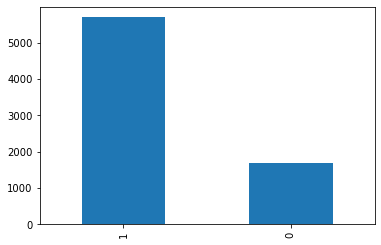

In [10]:
train_data['good/bad'].value_counts().plot(kind = 'bar')

In [11]:
print(train_data.groupby('good/bad').size().reset_index(name = 'count'))

   good/bad  count
0         0   1689
1         1   5702


In [12]:
print(train_data.isnull().values.any())

False


In [13]:
print(train_data.isnull().sum())

comment     0
good/bad    0
dtype: int64


In [14]:
print(train_data.isnull().sum())

comment     0
good/bad    0
dtype: int64


In [15]:
train_data.loc[train_data.comment.isnull()]

,comment,good/bad


In [16]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [17]:
print(len(train_data))

7391


In [18]:
eng_text = 'do!!! you expect... people~ to~ read~ the FAQ, etc. and actually accept hard~! atheism?@@'
print(re.sub(r'[^a-zA-Z ]', '', eng_text))

do you expect people to read the FAQ etc and actually accept hard atheism


In [19]:
train_data['comment'] = train_data['comment'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data[:5]

C:\Users\joony\AppData\Local\Temp/ipykernel_11192/3160313211.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['comment'] = train_data['comment'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


,comment,good/bad
0,진짜 오래감만에 웃으면서 봤던 영화입니다 새로운 스토리어색하지 않은 너무 좋아요 ...,1
1,좌빨 쓰레기 조작용으로 만들여젔는데 내용이 하도 부실하고 윤석열 깔것도 없으니 그냥...,0
2,너무 미국식 코미디라 호불호가 갈릴 듯 하지만 샤를리즈 테론의 미모와 연기가 열일함,1
3,마지막에 재회 장면은 최고의 장면임은 변함이 없다,1
4,새로운 세계 탐방하는 재미,1


In [20]:
train_data['comment'] = train_data['comment'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
train_data['comment'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

comment     28
good/bad     0
dtype: int64


C:\Users\joony\AppData\Local\Temp/ipykernel_11192/632833876.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['comment'] = train_data['comment'].str.replace('^ +', "") # white space 데이터를 empty value로 변경


In [21]:
train_data.loc[train_data.comment.isnull()][:5]

,comment,good/bad
234,NaN,1
237,NaN,1
651,NaN,1
787,NaN,0
1202,NaN,1


In [22]:
train_data = train_data.dropna(how = 'any')
print(len(train_data))

7363


In [24]:
test_data.drop_duplicates(subset = ['comment'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['comment'] = test_data['comment'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['comment'] = test_data['comment'].str.replace('^ +', "") # 공백은 empty 값으로 변경
test_data['comment'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 1847


C:\Users\joony\AppData\Local\Temp/ipykernel_11192/3309750423.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['comment'] = test_data['comment'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
C:\Users\joony\AppData\Local\Temp/ipykernel_11192/3309750423.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['comment'] = test_data['comment'].str.replace('^ +', "") # 공백은 empty 값으로 변경


In [25]:
test_data.head()

,comment,good/bad
0,대단히 재미있고 매력적일수 있었는데 이런 배우들을 가져다 요렇게밖에 못만드는것도 감...,0
1,재밌었습니다 액션도 최고였고 작화도 멋있었고 스토리도 좋았어요 다만 너무나도 기대를...,1
2,긴말 안한다 꼭 봐라 존잼이다,1
3,재밌었음 연기좋고 웃음도 빵빵 터졌음 대본을 배우들이 잘살린것 같음심각하지 않은 영...,1
4,재미있는데 류승용 아들역,1


In [26]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [27]:
okt = Okt()
okt.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔', stem = True)

['오다', '이렇다', '것', '도', '영화', '라고', '차라리', '뮤직비디오', '를', '만들다', '게', '나다', '뻔']

In [28]:
X_train = []
for sentence in tqdm(train_data['comment']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

100%|█████████████████████████████████████████████████████████████████████████████| 7363/7363 [00:20<00:00, 358.57it/s]


In [29]:
print(X_train[:3])

[['진짜', '오래', '감', '만에', '웃다', '보다', '영화', '이다', '새롭다', '스토리', '어색하다', '않다', '너무', '좋다', '많다', '사람', '보다', '좋다'], ['좌빨', '쓰레기', '조', '작용', '만들다', '젔', '늘다', '내용', '부실하다', '윤석열', '깔다', '없다', '그냥', '좌빨', '끼리', '쉬쉬', '쓰레기', '조', '작용', '영화', '한국', '영화', '또', '다른', '쓰레기', '선동', '용', '망작', '인데', '실패하다', 'ㅋㅋㅋ'], ['너무', '미국', '식', '코미디', '라', '호불호', '갈릴', '듯', '하지만', '샤를', '리즈', '테론', '미모', '연기', '열', '일', '함']]


In [31]:
X_test = []
for sentence in tqdm(test_data['comment']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

100%|█████████████████████████████████████████████████████████████████████████████| 1847/1847 [00:09<00:00, 200.24it/s]


In [32]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [33]:
print(tokenizer.word_index)

{'보다': 1, '영화': 2, '을': 3, '좋다': 4, '있다': 5, '너무': 6, '이다': 7, '없다': 8, '재밌다': 9, '되다': 10, '연기': 11, '적': 12, '같다': 13, '않다': 14, '다': 15, '만': 16, '로': 17, '스토리': 18, '에서': 19, '것': 20, '생각': 21, '배우': 22, '아니다': 23, '그': 24, '진짜': 25, '나오다': 26, '더': 27, '자다': 28, '안': 29, '인': 30, '만들다': 31, '사람': 32, '수': 33, '그냥': 34, '나': 35, '볼': 36, '감동': 37, '재미있다': 38, '하고': 39, '정말': 40, '연출': 41, '액션': 42, '고': 43, '게': 44, '못': 45, '보고': 46, '내': 47, '가다': 48, '때': 49, '싶다': 50, '시간': 51, '모르다': 52, '들다': 53, '많다': 54, '다시': 55, '최고': 56, '점': 57, '감독': 58, '까지': 59, '왜': 60, '말': 61, '요': 62, '그렇다': 63, '이렇다': 64, '느낌': 65, '사랑': 66, '장면': 67, '재미': 68, '저': 69, '내용': 70, '님': 71, '꼭': 72, '오다': 73, '거': 74, 'ㅋㅋ': 75, '평점': 76, '하나': 77, '많이': 78, '느끼다': 79, '주다': 80, '아쉽다': 81, '정도': 82, '알다': 83, '없이': 84, '년': 85, '지루하다': 86, '그리고': 87, '기대': 88, '이야기': 89, '작품': 90, '톰': 91, '마음': 92, '나다': 93, '우리': 94, '되어다': 95, '촛불': 96, '영': 97, '마지막': 98, '중': 99, '주인공': 100, '추천': 101, '임': 10

In [34]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 11190
등장 빈도가 2번 이하인 희귀 단어의 수: 6993
단어 집합에서 희귀 단어의 비율: 62.493297587131366
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 7.546923992252438


In [35]:
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 4198


In [36]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [37]:
print(X_train[:3])

[[25, 957, 173, 744, 258, 1, 2, 7, 430, 18, 471, 14, 6, 4, 54, 32, 1, 4], [1057, 294, 577, 3341, 31, 385, 70, 2156, 849, 1178, 8, 34, 1057, 1408, 294, 577, 3341, 2, 214, 2, 115, 189, 294, 369, 161, 1409, 110, 2440, 143], [6, 454, 431, 301, 148, 1058, 1953, 109, 259, 2802, 1328, 11, 1114, 144, 103]]


In [39]:
y_train = np.array(train_data['good/bad'])
y_test = np.array(test_data['good/bad'])


In [40]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [41]:
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

7354
7354


C:\Users\joony\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


리뷰의 최대 길이 : 267
리뷰의 평균 길이 : 14.474299700843078


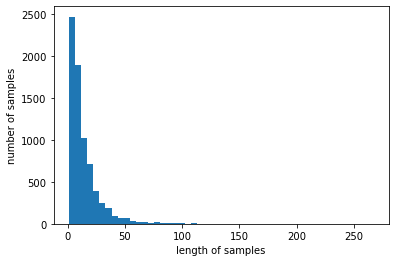

In [42]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [43]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [44]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 90.65814522708729


In [45]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [46]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [47]:
embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
89/92 [============================>.] - ETA: 0s - loss: 0.4970 - acc: 0.7772
Epoch 1: val_acc improved from -inf to 0.80829, saving model to best_model.h5
92/92 [==============================] - 4s 12ms/step - loss: 0.4944 - acc: 0.7775 - val_loss: 0.4176 - val_acc: 0.8083
Epoch 2/15
88/92 [===========================>..] - ETA: 0s - loss: 0.3309 - acc: 0.8572
Epoch 2: val_acc improved from 0.80829 to 0.83345, saving model to best_model.h5
92/92 [==============================] - 1s 10ms/step - loss: 0.3323 - acc: 0.8577 - val_loss: 0.3940 - val_acc: 0.8334
Epoch 3/15
92/92 [==============================] - ETA: 0s - loss: 0.2707 - acc: 0.8863
Epoch 3: val_acc improved from 0.83345 to 0.83889, saving model to best_model.h5
92/92 [==============================] - 1s 8ms/step - loss: 0.2707 - acc: 0.8863 - val_loss: 0.4295 - val_acc: 0.8389
Epoch 4/15
92/92 [==============================] - ETA: 0s - loss: 0.2342 - acc: 0.9041
Epoch 4: val_acc improved from 0.83889 to 0.8

In [48]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

58/58 [==============================] - 1s 6ms/step - loss: 0.4233 - acc: 0.8365

 테스트 정확도: 0.8365


In [49]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [50]:
sentiment_predict('이 영화 개꿀잼 ㅋㅋㅋ')

86.50% 확률로 긍정 리뷰입니다.



In [51]:
sentiment_predict('이 영화 핵노잼 ㅠㅠ')

90.15% 확률로 부정 리뷰입니다.



In [52]:
sentiment_predict('이딴게 영화냐 ㅉㅉ')

91.41% 확률로 부정 리뷰입니다.



In [53]:
sentiment_predict('감독 뭐하는 놈이냐?')

56.16% 확률로 긍정 리뷰입니다.



In [54]:
sentiment_predict('와 개쩐다 정말 세계관 최강자들의 영화다')

81.18% 확률로 긍정 리뷰입니다.



In [55]:
sentiment_predict('좋은 영화')

90.07% 확률로 긍정 리뷰입니다.



In [56]:
sentiment_predict('개쓰레기')

87.50% 확률로 부정 리뷰입니다.



In [57]:
sentiment_predict('바보')

64.49% 확률로 긍정 리뷰입니다.



In [58]:
sentiment_predict('멍청이')

62.87% 확률로 긍정 리뷰입니다.



In [59]:
sentiment_predict('천재')

90.49% 확률로 긍정 리뷰입니다.

